**Реализация LSTM cell через numpy**

In [1]:
import numpy as np

import matplotlib.pyplot as plt

<div>
<img src=lstm_images/l1.png width="500"/>
</div>
Ячейки LSTM

<div>
<img src="lstm_images/p.png" width="500"/>
</div>
Обозначения

<div>
<img src=lstm_images/l2.png width="500"/>
</div>
Определенить, какую информацию можно выбросить из состояния ячейки

<div>
<img src=lstm_images/l3.png width="500"/>
</div>
Решить, какая новая информация будет храниться в состоянии ячейки

<div>
<img src=lstm_images/l4.png width="500"/>
</div>
Заменить старое состояние ячейки $C_{t-1}$ на новое состояние $C_t$

<div>
<img src=lstm_images/l5.png width="500"/>
</div>
Решить, какую информацию мы хотим получать на выходе

**Решение задачи предсказания следующего слова**

In [4]:
# вспомогательные функции: one-hot encoding, создание последовательностей для работы, создание словаря

def generate_sequences(num_sequences=300, random=False):
    samples = []
    
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 10)
        sample_main = ['a'] * num_tokens + ['b'] * num_tokens
        if random:
            np.random.shuffle(sample_main)
        sample = sample_main + ['EOS']
        samples.append(sample)
        
    return samples

sequences = generate_sequences()

In [5]:
def sequences_to_dicts(sequences):
    # построение одного списка из всех последовательностей
    flatten = lambda l: [item for sublist in l for item in sublist]
    all_words = flatten(sequences)
    # Подсчет уникальных токенов в последовательностях
    word_count = {}
    for word in all_words:
        if word in word_count.keys():
            word_count[word] += 1
        else:
            word_count[word] = 1
    # Сортируем по частоте
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    # Список всех уникальных токенов
    unique_words = [item[0] for item in word_count]
    # Добавим UNK токен в список уникальных: нужно если встретим новое слово
    unique_words.append('UNK')
    # количество последовательностей и уникальных слов
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Построим словари
    word_to_idx = {}
    idx_to_word = {}
    
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size

word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

In [6]:
def create_datasets(sequences, p_train=0.8, p_val=0.1, p_test=0.1):
    # количество последовательностей в каждом поднаборе
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # разделим список последовательностей на поднаборы
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        inputs, targets = [], []
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])    
        return inputs, targets
    
    def get_dataset_generator(inputs, targets):
        for inp, tar in zip(inputs, targets):
            yield (inp, tar)

    # Получаем фичи и таргеты для каждого поднабора
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # создаем генераторы для каждого поднабора
    training_set = get_dataset_generator(inputs_train, targets_train)
    validation_set = get_dataset_generator(inputs_val, targets_val)
    test_set = get_dataset_generator(inputs_test, targets_test)

    return training_set, validation_set, test_set

In [45]:
training_set, validation_set, test_set = create_datasets(sequences)
training_set, validation_set, test_set = list(training_set), list(validation_set), list(test_set)

In [16]:
def one_hot_encode(idx, vocab_size):
    # представляем каждое слово как one-hot вектор
    one_hot = np.zeros(vocab_size)
    one_hot[idx] = 1.0
    return one_hot

def one_hot_encode_sequence(sequence, vocab_size):
    # преобразуем каждое слово в последовательности, получаем [num_sequences, vocab_size, 1]
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    return encoding

In [7]:
hidden_size = 50  # размерность латентного пространства
vocab_size  = len(word_to_idx)  # размер словаря

In [8]:
def init_orthogonal(param):
    # инициализация весов: берем параметры (https://arxiv.org/pdf/math-ph/0609050.pdf)
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    new_param = np.random.randn(rows, cols)
    if rows < cols:
        new_param = new_param.T
    
    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph
    if rows < cols:
        q = q.T
    new_param = q
    
    return new_param

In [9]:
def sigmoid(x):
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    return f

def sigmoid_deriv(x):
    x_s = sigmoid(x)
    return x_s * (1 - x_s)

def tanh(x):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    return f

def tanh_deriv(x):
    return 1 - tanh(x)**2

def softmax(x):
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    return f

In [10]:
# Сумма размера латентного вектора и входного вектора - потребуется при конкатенации ht-1 и xt
z_size = hidden_size + vocab_size 

def init_lstm(hidden_size, vocab_size, z_size):
    # инициализация всех весовых матриц в слое LSTM
    # forget gate
    W_f = np.random.randn(hidden_size, z_size)
    b_f = np.zeros((hidden_size, 1))  # bias

    # input gate
    W_i = np.random.randn(hidden_size, z_size)
    b_i = np.zeros((hidden_size, 1))

    # candidate - Ct_hat
    W_c = np.random.randn(hidden_size, z_size)
    b_c = np.zeros((hidden_size, 1))

    # output gate
    W_o = np.random.randn(hidden_size, z_size)
    b_o = np.zeros((hidden_size, 1))

    # веса для выходного "слоя"
    W_v = np.random.randn(vocab_size, hidden_size)
    b_v = np.zeros((vocab_size, 1))
    
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_c = init_orthogonal(W_c)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_c, W_o, W_v, b_f, b_i, b_c, b_o, b_v

In [11]:
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

In [12]:
def forward(inputs, h_prev, C_prev, p):
    """
    inputs -- последовательность X(t): (len_seq, m).
    h_prev -- Hidden state h(t-1):  (hidden_size, m)
    C_prev -- Состояние ячейки C(t-1): (hidden_size, m)
    p - список обучаемых параметров для каждого шага LSTM ячейки
    На выходе:
    z_s, f_s, i_s, g_c, C_s, o_s, h_s, v_s - список вычислений на каждом этапе (нужно для backward)
    outputs - предсказания на шаге t: (n_v, m), здесь к LSTM добавили линейный слой для вычисления итоговых предсказаний
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    W_f, W_i, W_c, W_o, W_v, b_f, b_i, b_c, b_o, b_v = p
    
    # списки для хранения результатов промежуточных вычислений
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_c, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    
    # храним начальные состояния ячейки и латентного "слоя"
    h_s.append(h_prev)
    C_s.append(C_prev)
    
    # идем ровно по схеме LSTM для каждой 
    for x in inputs:
        # объединяем вход и hidden_state
        z = np.row_stack((h_prev, x))
        z_s.append(z)

        # вычисляем forget gate как указано в формуле на схеме
        f = sigmoid(np.dot(W_f, z) + b_f)
        f_s.append(f)
        
        # вычисляем input gate
        i = sigmoid(np.dot(W_i, z) + b_i)
        i_s.append(i)
        
        # вычисляем candidate (С(t)_hat)
        c = tanh(np.dot(W_c, z) + b_c)
        g_c.append(c)
        
        # вычисляем новое состояние ячейки (C(t))
        C_prev = f * C_prev + i * c 
        C_s.append(C_prev)
        
        # вычисляем выход из ячейки LSTM
        o = sigmoid(np.dot(W_o, z) + b_o)
        o_s.append(o)
        
        # вычисляем h(t-1) - hidden_state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # вычисляем выход сети logits
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)
        
        # применяем softmax
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_c, C_s, o_s, h_s, v_s, output_s

In [13]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    подрезаем градиенты так, чтобы норма вектора весов не превышала заданный порог
    Таким образом мы предотвращаем "взрыв" градиентов
    """ 
    max_norm = float(max_norm)
    total_norm = 0
    
    # вычисляем квадрат L2 нормы каждого градиента и аккумулируем их в total_norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # определяем коэффициент для подрезки
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # если норма градиентов превышает допустимую, то подрезаем каждый градиент
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads

def backward(z, f, i, c, C, o, h, v, outputs, targets, p = params):
    """
    Подаем вычисления с forward pass и текущие значения весов во всех частях LSTM-cell
    Получаем значение функции потерь и значения вычисленных на каждом шаге градиентов
    """
    W_f, W_i, W_c, W_o, W_v, b_f, b_i, b_c, b_o, b_v = p

    # Зануляем градиенты (по аналогии с PyTorch: optimizer.zero_grad())
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_c_d = np.zeros_like(W_c)
    b_c_d = np.zeros_like(b_c)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Устанавливаем следующие значения ячейки и hidden_state в 0
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    loss = 0
    
    for t in reversed(range(len(outputs))):  # идем в обратном направлении (по аналогии: от вершин графа к началу)
        
        # вычисляем cross entropy
        loss -= np.mean(np.log(outputs[t]) * targets[t])
        # берем предыдущее значение ячейки
        C_prev= C[t-1]
        
        # вычисляем производную выхода по hidden_state и обновляем соответствующие веса
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1

        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # вычисляем производную hidden state и выхода, обновляем веса на выходе
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid_deriv(o[t]) * do
        
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # вычисляем производную C(t) и кандидата C(t)_hat и обновляем соответствующие веса
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh_deriv(tanh(C[t]))
        dc = dC * i[t]
        dc = tanh_deriv(c[t]) * dc
        
        W_c_d += np.dot(dc, z[t].T)
        b_c_d += dc

        # вычисляем производную input gate и обновляем соответствующие веса
        di = dC * c[t]
        di = sigmoid_deriv(i[t]) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # вычисляем производную forget gate и обновляем соответствующие веса
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # вычисляем производную на входе и обновляем веса C(t-1), h(t-1)
        dz = (np.dot(W_f.T, df) + np.dot(W_i.T, di) + np.dot(W_c.T, dc) + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads = W_f_d, W_i_d, W_c_d, W_o_d, W_v_d, b_f_d, b_i_d, b_c_d, b_o_d, b_v_d
    
    # подрезаем градиенты
    grads = clip_gradient_norm(grads)
    
    return loss, grads

In [14]:
def update_parameters(params, grads, lr=1e-3):
    # функция для обновления параметров сети
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

**Соберем все вместе**

Epoch 0, training loss: 2.141402711587014, validation loss: 3.2885032998166666
Epoch 10, training loss: 0.8373650800754653, validation loss: 0.815229374216115
Epoch 20, training loss: 0.6991599610368799, validation loss: 0.7285838213752872
Epoch 30, training loss: 0.7058006688789625, validation loss: 0.7118651832025098
Epoch 40, training loss: 0.74876888490035, validation loss: 0.6689255619627217
Epoch 50, training loss: 0.7652350093654167, validation loss: 0.6689943238596222
Epoch 60, training loss: 0.7731757524748584, validation loss: 0.6994437462185611
Epoch 70, training loss: 0.7273154729603952, validation loss: 0.6877123683680036
Epoch 80, training loss: 0.6856806411340195, validation loss: 0.6563393902498961
Epoch 90, training loss: 0.6518313661143267, validation loss: 0.6351913630632194
Epoch 100, training loss: 0.6447907310155416, validation loss: 0.6300643348625169
Epoch 110, training loss: 0.6440208689522087, validation loss: 0.6286942588785318
Epoch 120, training loss: 0.645

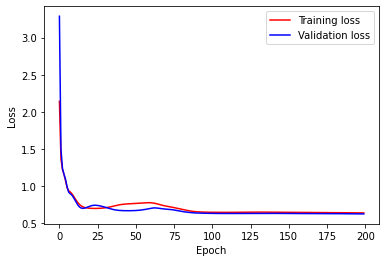

In [15]:
epochs = 200

# инициализируем наши слои, получив начальные веса
z_size = hidden_size + vocab_size
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Для LSTM инициализируем начальные значения hidden_state (надо с чего-то начинать)
hidden_state = np.zeros((hidden_size, 1))

# будем сохранять значения потерь
training_loss, validation_loss = [], []

for i in range(epochs):
    
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # для каждой последовательности в проверочном наборе
    for inputs, targets in validation_set:
        
        # кодируем последовательности через One-hot
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # инициализируем h_prev, C_prev нулями на старте
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Прямой проход
        z_s, f_s, i_s, g_c, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Обратный проход
        loss, _ = backward(z_s, f_s, i_s, g_c, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # аккумулируем потери
        epoch_validation_loss += loss
    
    # Теперь тренировочный набор
    for inputs, targets in training_set:
        
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        z_s, f_s, i_s, g_c, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        loss, grads = backward(z_s, f_s, i_s, g_c, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        params = update_parameters(params, grads, lr=1e-1)
        
        epoch_training_loss += loss
                
    training_loss.append(epoch_training_loss/len(list(training_set)))
    validation_loss.append(epoch_validation_loss/len(list(validation_set)))

    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


    
# берем первую пару из тестового набора
inputs, targets = next(iter(test_set))

# кодируем их
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# снова объявляем начальные значения C(t-1), h(t-1)
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Прогоняем через нашу сеть
z_s, f_s, i_s, g_c, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# График функции потерь
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Материалы:

* https://habr.com/ru/company/wunderfund/blog/331310/
* https://github.com/CaptainE/RNN-LSTM-in-numpy